# TP: Réseaux de neurones artificiels
# ===========================================================



L'objectif de cette séance de TP est d'implémenter depuis zéro une architecture réseau de neurone artificiel en utilisant la librarie numpy, puis d'entraîner ce réseau de neurone afin d'apprendre la fonction (non-linéaire):

$$
f^*(x_1, x_2) = x_1^2 + x_2^2
$$

à partir de données d'entraînement

$$
\{(x_n, y_n) \in \mathbb{R}^2 \times \mathbb{R}, n = 1, \dots, N \},
$$

pour lesquelles

$$
\forall n \in \{1, \dots, N \}, y_n = f^*(x_n) + \epsilon_n,
$$

où $\epsilon_n$ est un bruit blanc Gaussien de moyenne nulle et de variance $\sigma ^2$.

In [23]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

## 1. Génération des données d'entraînement et de test

La fonction ci-dessous permet de générer des données à partir du modèle.

In [24]:
def generate_dataset(nsamples, sigma=0.):
    
    """
    Generate a dataset with the specified number of samples
    
    :param nsamples: number of sample points
    :type nsamples: int
    :param sigma: standard deviation of the noise
    :type sigma: float
    
    :return: Generated dataset {(x_n, y_n), n = 1, ..., nsamples}
    :rtype: tuple of numpy arrays
    """

    x = np.zeros((nsamples, 2))
    x[:, 0] = np.random.uniform(-1, 1, nsamples)
    x[:, 1] = np.random.uniform(-1, 1, nsamples)

    eps = np.random.normal(loc=0, scale=sigma, size=nsamples)
    
    y = x[:, 0]**2 + x[:, 1]**2 + eps
    return x, y
    

In [31]:
nsamples = 50
sigma = 0.4
xtrain, ytrain = generate_dataset(nsamples, sigma)
xtest, ytest = generate_dataset(nsamples, sigma)

## 2. Implémentation d'une couche du réseau

Afin de modéliser les différentes couches du réseau de neurone, nous allons nous appuyer sur une classe, Layer, dont les attributs sont:

- la taille "input_dim" du signal à l'entrée de la couche 
- le nombre "output_dim" de neurones dans la couche
- la fonction d'activation "activation" utilisée par la couche ('RELU' ou aucune)
- la matrice "weights" des poids des neurones de la couche
- le vecteur "biases" des biais
- le signal d'entrée "input"
- le signal de sortie "output"
- les gradients "input_grad", "output_grad", "weights_grad", et "biases_grad" 

Compléter l'implémentation de la classe:

**Question 2.1.** Dans le constructeur, initialiser les valeurs de la matrice des poids et des biais.

**Question 2.2.** Implémenter le calcul du signal de sortie y de la couche en présence d'une entrée x. On rappelle ici que:

$$
y = \sigma (Wx) + b,
$$

où $\sigma $ est la fonction d'activation de la couche

**Question 2.3.** Implémenter l'algorithme de rétropropagation du gradient du signal de sortie "output_grad" dans la couche.

**Question 2.4.** Implémenter une méthode permettant de mettre à jour les valeurs des poids/biais de la couche connaissant le learning rate



In [32]:
class Layer:

    """
    Neural network layer implementation
    """

    def __init__(self, input_dim, output_dim, activation='RELU'):

        """
        :param input_dim: dimension of the input vector
        :type input_dim: integer

        :param output_dim: dimension of the output vector 
         (i.e number of neurons in the layer)
        :type output_dim: integer

        :param activation: activation function
        :type activation: string
        """

        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation

        self.weights = np.random.normal(loc=0, scale=1./np.sqrt(self.input_dim),
          size=(self.output_dim, self.input_dim))

        self.biases = np.zeros(self.output_dim)


    def forward(self, x):

        """
        Computes a forward pass in the layer

        :param x: input signal
        :type x: numpy array of size input_dim

        :return: output of the layer
        :rtype: numpy array of size output_dim
        """

        
        self.input = x
        self.output = np.dot(self.weights, self.input) + self.biases

        if(self.activation == 'RELU'):
            self.output = np.maximum(self.output, 0.)

        return self.output


    def backward(self, output_grad):

        """
        Computes a backward pass in the layer

        :param output_grad: gradient of the output of the layer w.r.t
         the training loss
        :type output_grad: numpy array of size output_dim

        :return: gradient of the output of the layer w.r.t
         the training loss
        :rtype: numpy array of size input_dim
        """

        self.output_grad = output_grad
        intermediate_grad = self.output_grad
        if(self.activation == 'RELU'):
            intermediate_grad *= (self.output > 0).astype('float')            

        
        self.weights_grad = np.dot(
          self.output_grad.reshape((self.output_dim, -1)),
          self.input.reshape((-1, self.input_dim))
          )

        self.biases_grad = self.output_grad
        self.input_grad = np.dot(self.weights.T, self.output_grad)
        return self.input_grad


    def update(self, learning_rate):

        """
        Update the weights during the gradient descent

        :param learning_rate: learning rate
        :type learning_rate: float
        """
    
        self.weights -= learning_rate*self.weights_grad
        self.biases -= learning_rate*self.biases_grad


## 3. Modèle linéaire

La classe Linear ci-après permet d'implémenter le modèle linéaire

$$
f^*(x_1, x_2) = w_1 x_1 + w_2 x_2
$$

associé à la fonction de coût correspondant à la norme $L^2$.
L'implémentation s'appuie sur la classe Layer: le modèle linéaire n'est en fait rien d'autre qu'une couche de réseau sans fonction d'activation.

Les attributs de la classe sont:
- les dimensions "input_dim" et "output_dim" des signaux d'entrée et de sortie
- l'instance de la classe Layer utilisée pour décrire le modèle
- le signal de sortie "output"
- la cible "target" utilisée lors de l'entraînement
- la valeur "loss" de la fonction de coût: 
$$
loss = (output - target)^2
$$
- le gradient "loss_grad" de la fonction de coût par rapport à la sortie du modèle

In [33]:
class Linear:

    """
    Linear model implementation
    """

    def __init__(self, input_dim, output_dim=1):


        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layer = Layer(self.input_dim, self.output_dim, activation='None')


    def forward(self, x):

        """
        Computes a forward pass in the neural network

        :param x: input signal
        :type x: numpy array of size input_dim

        :return: output of the neural network
        :rtype: float
        """
        self.output = self.layer.forward(x)


    def compute_loss(self, x, target):

        """
        Computes the loss 

        :param x: input signal
        :type x: numpy array of size input_dim

        :param target: target value
        :type target: float

        :return: loss
        :rtype: float
        """

        self.target = target
        self.forward(x)
        self.loss = (self.output - target)**2


    def backward(self):

        """
        Backpropagation in the neural network 
        """

        self.loss_grad = 2*(self.output - self.target)
        self.layer.backward(self.loss_grad)


    def update(self, learning_rate):

        """
        Update the weights of the network during the gradient descent

        :param learning_rate: learning rate
        :type learning_rate: float
        """

        self.layer.update(learning_rate)

## 4. Réseau de neurone

**Question 4.1** En vous inspirant de l'implémentation du modèle Linéaire, complétez l'implémentation de la classe TwoLayersNetwork ci-après

In [34]:
class TwoLayersNetwork:

    """
    Linear model implementation
    """

    def __init__(self, input_dim, hidden_dim, output_dim=1):
        
        """
        Model initialization
        
        :param input_dim: Dimension of the input signal
        :type input_dim: int
        
        :param hidden_dim: Dimension of the hidden layer
        :type input_dim: int
        
        :param output_dim: Dimension of the output signal
        :type output_dim: int
        """

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_layer = Layer(self.input_dim, self.hidden_dim, activation='RELU')
        self.output_layer = Layer(self.hidden_dim, self.output_dim, activation='None')


    def forward(self, x):

        """
        Computes a forward pass in the neural network

        :param x: input signal
        :type x: numpy array of size input_dim
        """

        self.output = self.output_layer.forward(self.input_layer.forward(x))


    def compute_loss(self, x, target):

        """
        Computes the loss 

        :param x: input signal
        :type x: numpy array of size input_dim

        :param target: target value
        :type target: float
        """

        self.target = target
        self.forward(x)
        self.loss = (self.output - target)**2


    def backward(self):

        """
        Backpropagation in the neural network 
        """

        self.loss_grad = 2*(self.output - self.target)
        self.input_layer.backward(self.output_layer.backward(self.loss_grad))


    def update(self, learning_rate):

        """
        Update the weights of the network during the gradient descent

        :param learning_rate: learning rate
        :type learning_rate: float
        """

        self.input_layer.update(learning_rate)
        self.output_layer.update(learning_rate)

## 5. Entraînement du modèle linéaire

Le code ci-dessous permet d'entraîner le modèle linéaire.

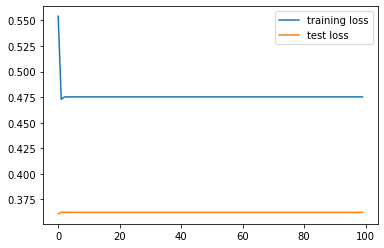

Minimal training error: 0.4727668047828905
Minimal test error: 0.36077099297373133


In [35]:
    # 1: Linear model

    input_dim = 2
    output_dim = 1
    nepochs = 100

    # Initializes the model
    linear = Linear(input_dim, output_dim)
    
    # Fix the learning rate
    learning_rate = 1e-1

    training_loss, test_loss = [], []
    for epoch in range(nepochs):
        
        train_err = []
        for n in range(nsamples):

            linear.compute_loss(xtrain[n], ytrain[n])
            linear.backward()
            linear.update(learning_rate)
            train_err.append(linear.loss)

        test_err = []
        for n in range(nsamples):

            linear.compute_loss(xtest[n], ytest[n])
            test_err.append(linear.loss)

        training_loss.append(np.array(train_err).mean())
        test_loss.append(np.array(test_err).mean())

    plt.plot(np.array(training_loss), label='training loss')
    plt.plot(np.array(test_loss), label='test loss')
    plt.legend()
    plt.show()

    print("Minimal training error: " + str(min(training_loss)))
    print("Minimal test error: " + str(min(test_loss)))

## 6. Entraînement du réseau de neurone

**Question 6.1.** En vous inspirant du modèle linéaire, implémentez l'entraînement du réseau de neurone sur les données

**Question 6.2.** Quelle est l'influence du nombre de neurones dans la couche cachée?

*Réponse*: Lorsqu'il n'y a pas de bruit dans les données d'apprentissage, on remarque qu'il est nécessaire d'avoir un nombre de neurones suffisants dans la couche cachée pour que le réseau soit capable d'approximer convenablement la fonction $f^*$.

En présence de bruit, on remarque cependant qu'augmenter le nombre de neurones dans la cache cachée, c'est à dire la dimension du modèle, conduit à un phénomène de sur-apprentissage: l'erreur d'apprentissage décroît avec le nombre d'époques, tandis que l'erreur croît dans le même temps sur la base de test à partir d'un certain point.

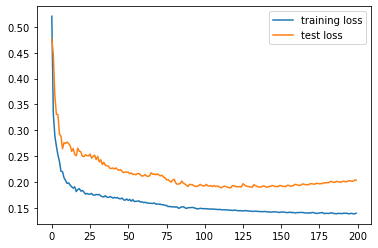

Minimal training error: 0.13819119381153439
Minimal test error: 0.18858944135568956


In [37]:
input_dim = 2
hidden_dim = 20
output_dim = 1
nepochs = 200
 
network = TwoLayersNetwork(input_dim, hidden_dim, output_dim)
learning_rate = 1e-1

training_loss, test_loss = [], []
for epoch in range(nepochs):

    train_err = []
    for n in range(nsamples):

        network.compute_loss(xtrain[n], ytrain[n])
        network.backward()
        network.update(learning_rate)
        train_err.append(network.loss)

    test_err = []
    for n in range(nsamples):

        network.compute_loss(xtest[n], ytest[n])
        test_err.append(network.loss)

    training_loss.append(np.array(train_err).mean())
    test_loss.append(np.array(test_err).mean())

plt.plot(np.array(training_loss), label='training loss')
plt.plot(np.array(test_loss), label='test loss')
plt.legend()
plt.show()

print("Minimal training error: " + str(min(training_loss)))
print("Minimal test error: " + str(min(test_loss)))

In [9]:
for n in range(20):
    network.forward(xtest[n])
    linear.forward(xtest[n])
    y = float(network.output)
    yl = float(linear.output)
    print("Actual: " + str(ytest[n]))
    print("Network: " + str(y) + ' err: ' + str(abs(y - ytest[n])))
    print("Linear model: " + str(yl) + ' err: ' + str(abs(yl - ytest[n])) + '\n')
    

Actual: 0.609325583394744
Network: 0.6786568866350053 err: 0.06933130324026138
Linear model: 0.7500085340105914 err: 0.14068295061584746

Actual: 0.697274548298506
Network: 0.705610732256704 err: 0.008336183958198018
Linear model: 0.544744020552834 err: 0.152530527745672

Actual: 1.1061420835815694
Network: 1.1279798584046936 err: 0.021837774823124212
Linear model: 0.48664517304050875 err: 0.6194969105410606

Actual: 0.28138570878708624
Network: 0.23132301247983972 err: 0.050062696307246524
Linear model: 0.6245125230050852 err: 0.34312681421799895

Actual: 0.3663380754763297
Network: 0.3623889540065293 err: 0.003949121469800365
Linear model: 0.7792443107834737 err: 0.412906235307144

Actual: 1.0640437178056579
Network: 1.0691881385927353 err: 0.005144420787077442
Linear model: 0.559183461283802 err: 0.5048602565218558

Actual: 0.7004051522637318
Network: 0.7262472805154572 err: 0.025842128251725383
Linear model: 0.681351679364227 err: 0.019053472899504764

Actual: 0.10030864912941145
N